# Skin Cancer Prediction

## Source Link: https://www.kaggle.com/datasets/usman7788/skin-cancer-dataset

### <b> For this project, we will be trying to build a model that can accurately predict skin cancer within patients. This means that we will be transforming and engineering the data so we can get the best model possible.

## Importing the Important Libraries

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pprint

from sklearn.tree import DecisionTreeClassifier # create a decision tree
from sklearn.tree import plot_tree # tree plotting
from sklearn.tree import export_text # tree classification rules in text format

from sklearn.model_selection import train_test_split # Holdout validation
from sklearn.model_selection import StratifiedKFold, cross_validate # KFold cross validation
from sklearn.metrics import accuracy_score # Obtain the accuracy_score

# Ensemble Methods
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier

# XGBoost
from xgboost import XGBClassifier

from scipy.stats import uniform, randint

# Alternative Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm ## Generate coefficient statistics for logistic regression
from sklearn.svm import LinearSVC, SVC

# Evaluation 
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # accuracy and confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report # precision, recall, and f1
from sklearn.metrics import RocCurveDisplay, roc_auc_score # roc and auc

# Pipeline and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

#For Undersampling. This line of code originates from Claude
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%precision 4
# Ignore useless warnings (seeSciPy issue #5998)
import warnings
warnings.filterwarnings("ignore")

%precision 4

'%.4f'

## Initial Data Exploration and Cleaning

### For this section, we will check the dataset for null values and see if the class label "Skin Cancer" is balanced.

In [3]:
# Read the .csv file and store it as a pandas DataFrame
Cancer_initial = pd.read_csv("Skin cancer.csv")

# Get the shape
print(Cancer_initial.shape)

(319795, 18)


In [4]:
Cancer_initial.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [5]:
Cancer_initial.nunique()

HeartDisease           2
BMI                 3604
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             24
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

In [6]:
Cancer_initial.isnull().sum().sum()

0

0    0.906756
1    0.093244
Name: SkinCancer, dtype: float64


<Axes: xlabel='SkinCancer', ylabel='count'>

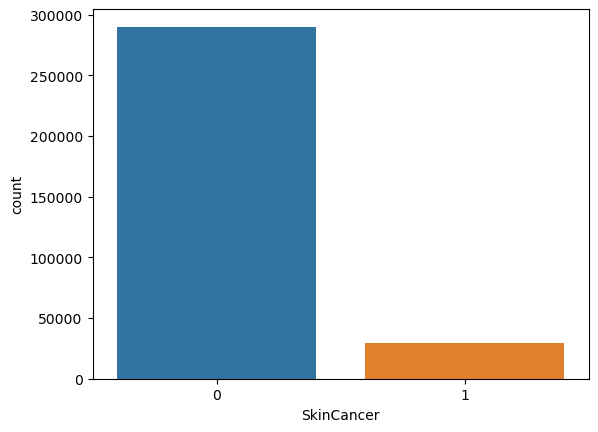

In [7]:
Cancer_initial["SkinCancer"] = Cancer_initial.SkinCancer.map({"Yes":1, "No":0})
print(Cancer_initial.SkinCancer.value_counts()/Cancer_initial.SkinCancer.count())
sns.countplot(x='SkinCancer', data=Cancer_initial)

From the code, we can see that the dataset contains 319795 items with 18 attributes, has zero null values, and is heavily unbalanced with a minority class of 1. In other words, fewer people have skin cancer in the dataset.

## Data Transformation

In order to get the data ready for modelling, we need to change some of the variables. Primarily, we will be changing any attributes with binaries into 1s-and-0s and dummy variables.

In [8]:
def data_form(df):
    try:
        # Categorical variables → dummies
        dum_var = [
            "Race", "Diabetic", "GenHealth", "AgeCategory", "Sex"
        ]

        existing_dum = [col for col in dum_var if col in df.columns]

        if existing_dum:
            df = pd.get_dummies(df, columns=existing_dum, drop_first=True)
        else:
            print("Warning: No dummy variables found in DataFrame.")

        # Binary variables → 0/1
        bin_var = [
            "HeartDisease", "Smoking", "AlcoholDrinking", "Stroke",
            "DiffWalking", "Asthma", "KidneyDisease", "PhysicalActivity"
        ]

        for col in bin_var:
            if col in df.columns:
                df[col] = df[col].map({"Yes": 1, "No": 0})
            else:
                print(f"Warning: Column '{col}' not found in DataFrame.")

    except Exception as e:
        print(f"Error during data preparation: {e}")

    return df


In [9]:
#Creates a cleaned version of the dataset
Cancer = data_form(Cancer_initial)
Cancer.to_csv("Cancer_clean.csv", index = False)

In [10]:
Cancer.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,SleepTime,...,AgeCategory_40-44,AgeCategory_45-49,AgeCategory_50-54,AgeCategory_55-59,AgeCategory_60-64,AgeCategory_65-69,AgeCategory_70-74,AgeCategory_75-79,AgeCategory_80 or older,Sex_Male
0,0,16.60,1,0,0,3.0,30.0,0,1,5.0,...,0,0,0,1,0,0,0,0,0,0
1,0,20.34,0,0,1,0.0,0.0,0,1,7.0,...,0,0,0,0,0,0,0,0,1,0
2,0,26.58,1,0,0,20.0,30.0,0,1,8.0,...,0,0,0,0,0,1,0,0,0,1
3,0,24.21,0,0,0,0.0,0.0,0,0,6.0,...,0,0,0,0,0,0,0,1,0,0
4,0,23.71,0,0,0,28.0,0.0,1,1,8.0,...,1,0,0,0,0,0,0,0,0,0


In [11]:
Cancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   HeartDisease                      319795 non-null  int64  
 1   BMI                               319795 non-null  float64
 2   Smoking                           319795 non-null  int64  
 3   AlcoholDrinking                   319795 non-null  int64  
 4   Stroke                            319795 non-null  int64  
 5   PhysicalHealth                    319795 non-null  float64
 6   MentalHealth                      319795 non-null  float64
 7   DiffWalking                       319795 non-null  int64  
 8   PhysicalActivity                  319795 non-null  int64  
 9   SleepTime                         319795 non-null  float64
 10  Asthma                            319795 non-null  int64  
 11  KidneyDisease                     319795 non-null  i

Our data has now been transformed. We can know beginning assigning our testing and training sets.

## Setup for Modelling

In [12]:
#Dropping the class label
X = Cancer.drop("SkinCancer", axis=1)
y = Cancer["SkinCancer"]

In [13]:
print(X.shape)
print(y.shape)

(319795, 37)
(319795,)


In [14]:
target_name = "SkinCancer"

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

oversampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

# Obtain attribute(feature) names (used for tree visualization)
fnames = list(X_train_over.columns)
print(fnames)

# Obtain the index (row identifier)
findex = X_train_over.index

# Obtain class label names
cnames = np.sort(y_train_over.unique())
# notice that survived outcome is numbers. we need to convert to str for future use.
cnames = [str(x) for x in cnames] 

print(cnames)

['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease', 'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White', 'Diabetic_No, borderline diabetes', 'Diabetic_Yes', 'Diabetic_Yes (during pregnancy)', 'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good', 'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54', 'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69', 'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older', 'Sex_Male']
['0', '1']


## Logistic Regression

In [15]:
# Define pipeline
lg_pp = Pipeline([
    ('standard', StandardScaler()), 
    ('logistic_regression', LogisticRegression(random_state=42))
])


# Train model
lg_pp.fit(X_train_over, y_train_over)

# Predict and evaluate
y_test_pp = lg_pp.predict(X_test)

print(f"The test data performance for logistic regression is {accuracy_score(y_test, y_test_pp):.2%}")
print(classification_report(y_test, y_test_pp, digits=4))

The test data performance for logistic regression is 65.75%
              precision    recall  f1-score   support

           0     0.9718    0.6410    0.7724     57995
           1     0.1900    0.8189    0.3084      5964

    accuracy                         0.6575     63959
   macro avg     0.5809    0.7299    0.5404     63959
weighted avg     0.8989    0.6575    0.7292     63959



In [16]:
logit_model = sm.Logit(y_train_over,X_train_over) 
result = logit_model.fit()
print(result.summary2())

#Part from AI. Changed threshold to 95% to be more accurate.  
sorted_features = result.summary2().tables[1]
significant_features = sorted_features[sorted_features['P>|z|'] < 0.05]

print("Significant features at 95% confidence level:")
print(significant_features)

Optimization terminated successfully.
         Current function value: 0.536704
         Iterations 7
                                 Results: Logit
Model:                   Logit                 Method:                MLE        
Dependent Variable:      SkinCancer            Pseudo R-squared:      0.226      
Date:                    2026-02-15 14:00      AIC:                   498094.3483
No. Observations:        463962                BIC:                   498503.1079
Df Model:                36                    Log-Likelihood:        -2.4901e+05
Df Residuals:            463925                LL-Null:               -3.2159e+05
Converged:               1.0000                LLR p-value:           0.0000     
No. Iterations:          7.0000                Scale:                 1.0000     
---------------------------------------------------------------------------------
                                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------

## Decision Tree

In [17]:
#Parameters were set to these after some repeated runs
MAX_DEPTH = 5
CRITERION = "entropy"
RANDOM_STATE = 42
MIN_SPLIT = 5
MIN_LEAF = 8
MAX_NODES = 7
IMP_DECREASE=0.003

In [18]:
# Decision Tree Classifier
dt1 = DecisionTreeClassifier(max_depth = MAX_DEPTH, criterion = CRITERION, 
                            max_leaf_nodes = MAX_NODES, min_samples_leaf = MIN_LEAF, 
                            min_samples_split = MIN_SPLIT, min_impurity_decrease = IMP_DECREASE, random_state = RANDOM_STATE)
dt1 = dt1.fit(X_train_over, y_train_over)
y_pred_train = dt1.predict(X_train_over)
accuracy_score(y_train_over, y_pred_train)

0.7172

In [19]:
y_pred_test = dt1.predict(X_test)
accuracy_score(y_pred_test, y_test)


print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           0     0.9582    0.7430    0.8370     57995
           1     0.2152    0.6851    0.3275      5964

    accuracy                         0.7376     63959
   macro avg     0.5867    0.7141    0.5822     63959
weighted avg     0.8889    0.7376    0.7895     63959



Top 10 Most Important Features:
                    Feature  Importance
16               Race_White    0.413469
33        AgeCategory_70-74    0.152810
35  AgeCategory_80 or older    0.152538
32        AgeCategory_65-69    0.132503
34        AgeCategory_75-79    0.123402
15               Race_Other    0.025279
0              HeartDisease    0.000000
25        AgeCategory_30-34    0.000000
22           GenHealth_Poor    0.000000
23      GenHealth_Very good    0.000000


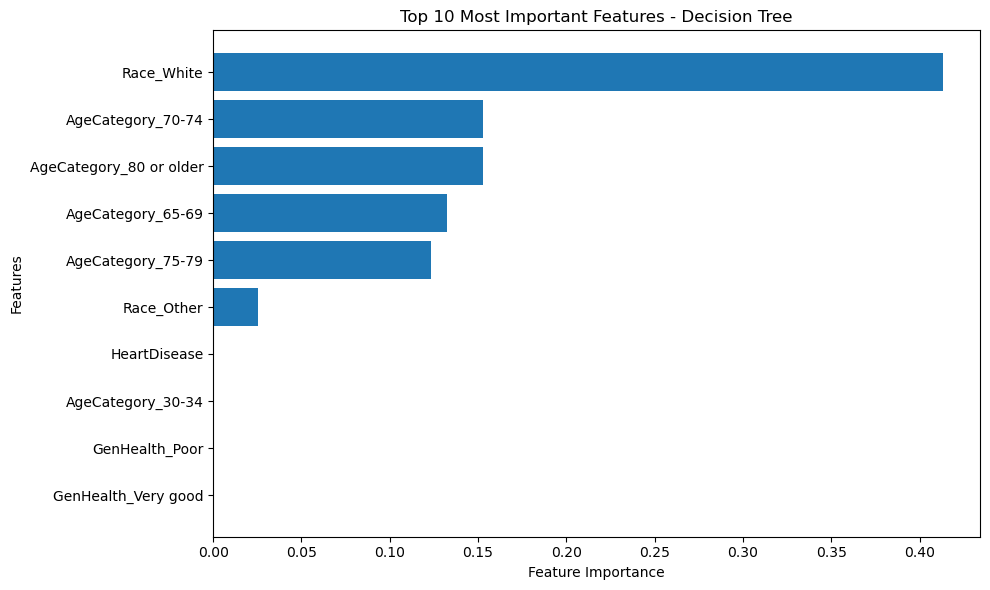

In [20]:
feature_importances = dt1.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train_over.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Display top features
print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Create bar graph
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features - Decision Tree')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

Alright then, we get a pretty decent accuracy score of 73% and recall score of 68% with the decision tree model. Recall for this dataset is important due to false negatives, i.e. those with cancer that don't get flagged, are really costly. As such, we want to prioritize this score a little bit more than overall accuracy. Also, due to most of the variables in the dataset being either categorical or binary, we will primarily be using decision tree methods.

## Feature Engineering

The feature engineering is designed to improve the model by transforming the data. Since age plays a large role, we will make the variable ordinal in order to see how it effects the possibility of skin cancer. Additionally, the general health variable will also be made ordinal. 

In [21]:
#Figures out the unique value of Diabetic
Cancer_initial["Diabetic"].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)'],
      dtype=object)

In [22]:
def engineer_SkinCancer_features(df):
    
    #Create engineered features based on top predictors
    df = df.copy()
    
    #Creates dummies for Race and Sex
    dum_var = [
            "Race", "Sex"
        ]

    existing_dum = [col for col in dum_var if col in df.columns]

    if existing_dum:
        df = pd.get_dummies(df, columns=existing_dum, drop_first=True)
    else:
        print("Warning: No dummy variables found in DataFrame.")

        # Binary variables → 0/1
    bin_var = [
            "HeartDisease", "Smoking", "AlcoholDrinking", "Stroke",
            "DiffWalking", "Asthma", "KidneyDisease", "PhysicalActivity"
        ]

    for col in bin_var:
        if col in df.columns:
            df[col] = df[col].map({"Yes": 1, "No": 0})
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    
    #Makes age an ordinal variable
    age = {
    '18-24': 1,
    '25-29': 2,
    '30-34': 3,
    '35-39': 4,
    '40-44': 5,
    '45-49': 6,
    '50-54': 7,
    '55-59': 8,
    '60-64': 9,
    '65-69': 10,
    '70-74': 11,
    '75-79': 12,
    '80 or older': 13
       }

    

    df['Age_Ordinal'] = df['AgeCategory'].map(age)
    
    #Makes genhealth an ordinal variable
    genhealth_map = {
    'Poor': 1,
    'Fair': 2,
    'Good': 3,
    'Very good': 4,
    'Excellent': 5
        }
    
    df['GenHealth_Ord'] = df['GenHealth'].map(genhealth_map)
    
    #Makes diabetes an ordinal variable
    diabetic_map = {
        'No': 0,
        'Yes (during pregnancy)': 0,
        'No, borderline diabetes': 0.5,
        'Yes': 1,
    }
    
    df['diabetic_ord'] = df['Diabetic'].map(diabetic_map)
    
    #Creates several additional variables based on extreme measures
    df['Age_65_plus'] = (df['Age_Ordinal'] >= 10).astype(int)
    df['BMI_Obese'] = (df['BMI'] >= 30).astype(int)
    df['Sleep_Short'] = (df['SleepTime'] < 6).astype(int)
    df['Sleep_Long'] = (df['SleepTime'] > 8).astype(int)

    
    #Chronic_Count is meant to encapsulate those with chronic conditions
    df['Chronic_Count'] = (
    df['Asthma'] +
    df['Stroke'] +
    df['KidneyDisease'] +
    df['diabetic_ord']
      )

    
    #Creates two variables combine age, physical activity, and smoking
    df['Old_and_Active'] = (
    (df['Age_Ordinal'] >= 8) &
    (df['PhysicalActivity'] == 1)
             ).astype(int)

    df['Old_and_Smoker'] = (
     (df['Age_Ordinal'] >= 8) &
     (df['Smoking'] == 1)
             ).astype(int)

    #Creates a UV_Risk variable that tries to encapsulates overall risk of skin cancer
    df['UV_Risk'] = (
    2 * (df['Race_White'] == 1).astype(int) +
    2 * (df['Age_Ordinal'] >= 8).astype(int) +
    1 * (df['PhysicalActivity'] == 1).astype(int)
    )

    #Drops several of the variables
    df = df.drop("Diabetic", axis = 1)
    df = df.drop("AgeCategory", axis = 1)
    df = df.drop("GenHealth", axis = 1)
    
    return df

In [23]:
#Transforms the original Skin Cancer dataset into SkinCance_engineered
SkinCancer_engineered = engineer_SkinCancer_features(Cancer_initial)

In [24]:
SkinCancer_engineered.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,PhysicalActivity,SleepTime,...,GenHealth_Ord,diabetic_ord,Age_65_plus,BMI_Obese,Sleep_Short,Sleep_Long,Chronic_Count,Old_and_Active,Old_and_Smoker,UV_Risk
0,0,16.60,1,0,0,3.0,30.0,0,1,5.0,...,4,1.0,0,0,1,0,2.0,1,1,5
1,0,20.34,0,0,1,0.0,0.0,0,1,7.0,...,4,0.0,1,0,0,0,1.0,1,0,5
2,0,26.58,1,0,0,20.0,30.0,0,1,8.0,...,2,1.0,1,0,0,0,2.0,1,1,5
3,0,24.21,0,0,0,0.0,0.0,0,0,6.0,...,3,0.0,1,0,0,0,0.0,0,0,4
4,0,23.71,0,0,0,28.0,0.0,1,1,8.0,...,4,0.0,0,0,0,0,0.0,0,0,3


In [25]:
#Looks for null values
SkinCancer_engineered.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
PhysicalActivity    0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
Race_Asian          0
Race_Black          0
Race_Hispanic       0
Race_Other          0
Race_White          0
Sex_Male            0
Age_Ordinal         0
GenHealth_Ord       0
diabetic_ord        0
Age_65_plus         0
BMI_Obese           0
Sleep_Short         0
Sleep_Long          0
Chronic_Count       0
Old_and_Active      0
Old_and_Smoker      0
UV_Risk             0
dtype: int64

In [26]:
SkinCancer_engineered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  int64  
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  int64  
 8   PhysicalActivity  319795 non-null  int64  
 9   SleepTime         319795 non-null  float64
 10  Asthma            319795 non-null  int64  
 11  KidneyDisease     319795 non-null  int64  
 12  SkinCancer        319795 non-null  int64  
 13  Race_Asian        319795 non-null  uint8  
 14  Race_Black        319795 non-null  uint8  
 15  Race_Hispanic     319795 non-null  uint8  
 16  Race_Other        31

In [27]:
print(f"Original features: {Cancer_initial.shape[1]}")
print(f"With engineered features: {SkinCancer_engineered.shape[1]}")
print(f"New features added: {SkinCancer_engineered.shape[1] - Cancer_initial.shape[1]}")

Original features: 18
With engineered features: 30
New features added: 12


## Re-Defining Variables

In [28]:
#Dropping the class label
X = SkinCancer_engineered.drop("SkinCancer", axis=1)
y = SkinCancer_engineered["SkinCancer"]

In [29]:
print(X.shape)
print(y.shape)

(319795, 29)
(319795,)


In [30]:
target_name = "SkinCancer"

X_train_engineered, X_test_engineered, y_train_engineered, y_test_engineered = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


# Obtain attribute(feature) names (used for tree visualization)
fnames = list(X_train_engineered.columns)
print(fnames)

# Obtain the index (row identifier)
findex = X_train_engineered.index

# Obtain class label names
cnames = np.sort(y_train_engineered.unique())
# notice that survived outcome is numbers. we need to convert to str for future use.
cnames = [str(x) for x in cnames] 

print(cnames)

['HeartDisease', 'BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'PhysicalActivity', 'SleepTime', 'Asthma', 'KidneyDisease', 'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White', 'Sex_Male', 'Age_Ordinal', 'GenHealth_Ord', 'diabetic_ord', 'Age_65_plus', 'BMI_Obese', 'Sleep_Short', 'Sleep_Long', 'Chronic_Count', 'Old_and_Active', 'Old_and_Smoker', 'UV_Risk']
['0', '1']


## Decision Tree

In [31]:
#Parameters were set to these after some repeated runs
MAX_DEPTH = 5
CRITERION = "entropy"
RANDOM_STATE = 42
MIN_SPLIT = 5
MIN_LEAF = 8
MAX_NODES = 7
IMP_DECREASE=0.003
CLASS = "balanced"

In [32]:
# Decision Tree Classifier
dt1 = DecisionTreeClassifier(max_depth = MAX_DEPTH, criterion = CRITERION, 
                            max_leaf_nodes = MAX_NODES, min_samples_leaf = MIN_LEAF, 
                            min_samples_split = MIN_SPLIT, min_impurity_decrease = IMP_DECREASE, random_state = RANDOM_STATE,
                            class_weight = CLASS)
dt1 = dt1.fit(X_train_engineered, y_train_engineered)
y_pred_train = dt1.predict(X_train_engineered)
accuracy_score(y_train_engineered, y_pred_train)

0.6132

In [33]:
y_pred_test = dt1.predict(X_test_engineered)
accuracy_score(y_pred_test, y_test_engineered)


print(classification_report(y_test, y_pred_test, digits=4))

              precision    recall  f1-score   support

           0     0.9761    0.5874    0.7335     57995
           1     0.1766    0.8602    0.2930      5964

    accuracy                         0.6129     63959
   macro avg     0.5763    0.7238    0.5132     63959
weighted avg     0.9015    0.6129    0.6924     63959



Top 10 Most Important Features:
           Feature  Importance
28         UV_Risk    0.795105
18     Age_Ordinal    0.159944
13      Race_Black    0.030788
16      Race_White    0.014164
15      Race_Other    0.000000
27  Old_and_Smoker    0.000000
26  Old_and_Active    0.000000
25   Chronic_Count    0.000000
24      Sleep_Long    0.000000
23     Sleep_Short    0.000000


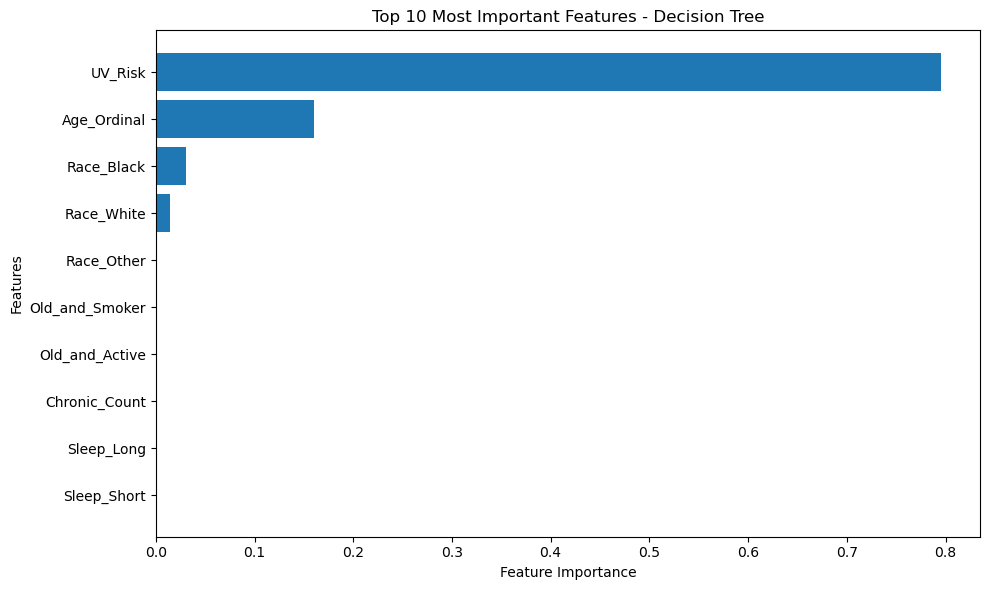

In [34]:
feature_importances = dt1.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train_engineered.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

# Display top features
print("Top 10 Most Important Features:")
print(importance_df.head(10))

# Create bar graph
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Most Important Features - Decision Tree')
plt.gca().invert_yaxis()  # Highest importance at top
plt.tight_layout()
plt.show()

Increases recall to 86.02% while accuracy decreases 61.3%. We see that UV_Risk and Age_Ordinal are really important to the model. The race variables are also a little important. We will now use grid searches and ensembles to get higher scores.

## Grid Search Decision Tree

In [35]:
#Configure the model setting
rbf_dt_clf = Pipeline([
        ('tree_clf', DecisionTreeClassifier(random_state = 42, class_weight = 'balanced',
                                           criterion = "entropy"))])


# Set tuning parameters, using distributions to specify a wide range of parameters
# Parameters of pipelines can be set using ‘__’ (double-underscore) separated parameter 
parameters = {
    'tree_clf__max_depth': randint(3, 7),
    'tree_clf__max_leaf_nodes': randint(5, 25), 
    'tree_clf__min_samples_leaf': randint(5, 20),
    'tree_clf__min_impurity_decrease': (0.0, 0.1)
}




# Use the n_iter to control the number of paramter combinations.
rand_clf = RandomizedSearchCV(rbf_dt_clf, 
                              parameters, 
                              n_iter = 20, 
                              random_state = 1, 
                              cv = 3, 
                              verbose = 3,
                              scoring = 'recall', 
                              return_train_score = True)
rand_clf.fit(X_train_engineered, y_train_engineered)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END tree_clf__max_depth=4, tree_clf__max_leaf_nodes=16, tree_clf__min_impurity_decrease=0.0, tree_clf__min_samples_leaf=13;, score=(train=0.796, test=0.793) total time=   0.4s
[CV 2/3] END tree_clf__max_depth=4, tree_clf__max_leaf_nodes=16, tree_clf__min_impurity_decrease=0.0, tree_clf__min_samples_leaf=13;, score=(train=0.853, test=0.855) total time=   0.4s
[CV 3/3] END tree_clf__max_depth=4, tree_clf__max_leaf_nodes=16, tree_clf__min_impurity_decrease=0.0, tree_clf__min_samples_leaf=13;, score=(train=0.795, test=0.795) total time=   0.6s
[CV 1/3] END tree_clf__max_depth=6, tree_clf__max_leaf_nodes=14, tree_clf__min_impurity_decrease=0.1, tree_clf__min_samples_leaf=10;, score=(train=0.866, test=0.864) total time=   0.4s
[CV 2/3] END tree_clf__max_depth=6, tree_clf__max_leaf_nodes=14, tree_clf__min_impurity_decrease=0.1, tree_clf__min_samples_leaf=10;, score=(train=0.863, test=0.869) total time=   0.3s
[CV 3/3] END t

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('tree_clf',
                                              DecisionTreeClassifier(class_weight='balanced',
                                                                     criterion='entropy',
                                                                     random_state=42))]),
                   n_iter=20,
                   param_distributions={'tree_clf__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002110C873D90>,
                                        'tree_clf__max_leaf_nodes': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000002110D6F23D0>,
                                        'tree_clf__min_impurity_decrease': (0.0,
                                                                            0.1),
                                        'tree_clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000021109B186D0>},
                   random_state=1, return_train_score=True, scoring='recall',
                   verbose=3)

In [36]:
best_tree = rand_clf.best_estimator_

print("Best parameters:", rand_clf.best_params_)
print("Best CV recall:", rand_clf.best_score_)

Best parameters: {'tree_clf__max_depth': 6, 'tree_clf__max_leaf_nodes': 14, 'tree_clf__min_impurity_decrease': 0.1, 'tree_clf__min_samples_leaf': 10}
Best CV recall: 0.865227292147637


In [37]:
y_test_rand = best_tree.predict(X_test_engineered)

print(classification_report(y_test_engineered, y_test_rand, digits = 4))

              precision    recall  f1-score   support

           0     0.9761    0.5874    0.7335     57995
           1     0.1766    0.8602    0.2930      5964

    accuracy                         0.6129     63959
   macro avg     0.5763    0.7238    0.5132     63959
weighted avg     0.9015    0.6129    0.6924     63959



Pretty high recall score.

## Random Forest

In [38]:
rf_clf = RandomForestClassifier(max_depth = 15, max_features = 0.9, #Percentage of subset of columns in each dataset
                                n_estimators = 100, #number of trees
                                random_state = 1, class_weight = 'balanced')

rf_clf.fit(X_train_engineered, y_train_engineered)

# test
y_test_rf = rf_clf.predict(X_test_engineered)
acc_rf = accuracy_score(y_test_engineered, y_test_rf)

print(f"The test data performance for Random Forest is {acc_rf:.2%}")
print(classification_report(y_test_engineered, y_test_rf, digits = 4))

The test data performance for Random Forest is 72.80%
              precision    recall  f1-score   support

           0     0.9550    0.7346    0.8304     57995
           1     0.2045    0.6635    0.3127      5964

    accuracy                         0.7280     63959
   macro avg     0.5798    0.6990    0.5715     63959
weighted avg     0.8850    0.7280    0.7822     63959



## Neural Network

In [39]:
# Train
nn = MLPClassifier(hidden_layer_sizes = (100, 150, 100), 
                   #Alpha is similar to c
                   alpha = 0.0001, # L2 penalty (regularization term) parameter. Change it to be 0.0001
                   max_iter = 1000,
                   activation = 'relu', 
                   learning_rate = "adaptive",
                   learning_rate_init = 0.1,
                   random_state = 42)
nn.fit(X_train_engineered, y_train_engineered)

# Test
y_test_nn = nn.predict(X_test_engineered)
acc_nn = accuracy_score(y_test_engineered, y_test_nn)
print(f"The test data performance for the neural network is {acc_nn:.2%}")
print(classification_report(y_test_engineered, y_test_nn, digits = 4))

The test data performance for the neural network is 90.68%
              precision    recall  f1-score   support

           0     0.9068    1.0000    0.9511     57995
           1     0.0000    0.0000    0.0000      5964

    accuracy                         0.9068     63959
   macro avg     0.4534    0.5000    0.4755     63959
weighted avg     0.8222    0.9068    0.8624     63959



While this model has a high accuracy, it has a 0 recall score. 
This means that the model essentially predicts that no one has skin cancer

## Decision Tree with a custom scorer

In [40]:
#A custom score might help in making prediction that score well in recall
from sklearn.metrics import make_scorer

def custom_metric(y_true, y_pred):
    return 0.7 * recall_score(y_true, y_pred) + 0.3 * accuracy_score(y_true, y_pred)

custom_scorer = make_scorer(custom_metric)


dt = DecisionTreeClassifier(random_state=42, class_weight = "balanced")

param_distributions = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": randint(2, 40),                 
    "min_samples_split": randint(2, 50),
    "min_samples_leaf": randint(1, 30),
    "max_features": [None, "sqrt", "log2"]
}

rand_search = RandomizedSearchCV(
    estimator=dt,
    param_distributions=param_distributions,
    n_iter=30,                 
    scoring= custom_scorer,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rand_search.fit(X_train_engineered, y_train_engineered)
print("RandomizedSearchCV best params:", rand_search.best_params_)
print("RandomizedSearchCV best CV acc:", rand_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
RandomizedSearchCV best params: {'criterion': 'log_loss', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 26, 'min_samples_split': 15}
RandomizedSearchCV best CV acc: 0.7896102366712586


In [41]:
best = rand_search.best_estimator_

best.fit(X_train_engineered, y_train_engineered)
y_pred_test = best.predict(X_test_engineered)
accuracy_score(y_test_engineered, y_pred_test)
print(classification_report(y_test_engineered, y_pred_test, digits = 4))

              precision    recall  f1-score   support

           0     0.9761    0.5874    0.7335     57995
           1     0.1766    0.8602    0.2930      5964

    accuracy                         0.6129     63959
   macro avg     0.5763    0.7238    0.5132     63959
weighted avg     0.9015    0.6129    0.6924     63959



## XgBoost and Search

In [42]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, fbeta_score, classification_report
import pandas as pd

# STEP 1: Calculate scale_pos_weight FIRST (before creating the classifier)
class_counts = pd.Series(y_train_engineered).value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]
f2_scorer = make_scorer(fbeta_score, beta=2)

print("="*60)
print("CLASS IMBALANCE ANALYSIS")
print("="*60)
print(f"Negative class (0): {class_counts[0]:,} samples")
print(f"Positive class (1): {class_counts[1]:,} samples")
print(f"Imbalance ratio: {scale_pos_weight:.2f}:1")
print(f"Using scale_pos_weight: {scale_pos_weight:.2f}")
print("="*60)

# STEP 2: NOW create XGBoost classifier with the calculated value
xgb_clf = XGBClassifier(
    scale_pos_weight=scale_pos_weight,  # Now this variable exists!
    random_state=1,
    eval_metric='logloss',
    tree_method='hist',
    n_jobs=-1
)

# STEP 3: Parameter grid
param_dist_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}

# STEP 4: Create scorer. Scorer is meant to value recall more than accuracy
f2_scorer = make_scorer(fbeta_score, beta=2)

# STEP 5: Hyperparameter search
xgb_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring=f2_scorer,
    cv=3,
    random_state=1,
    n_jobs=-1,
    verbose=2
)

print("\nStarting hyperparameter search...")
xgb_search.fit(X_train_engineered, y_train_engineered)

print("\n" + "="*60)
print("BEST PARAMETERS FOUND")
print("="*60)
print(xgb_search.best_params_)
print(f"Best CV F2 Score: {xgb_search.best_score_:.4f}")

# STEP 6: Evaluate on test set
best_xgb = xgb_search.best_estimator_
y_pred = best_xgb.predict(X_test_engineered)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(classification_report(y_test_engineered, y_pred, digits=4))

CLASS IMBALANCE ANALYSIS
Negative class (0): 231,981 samples
Positive class (1): 23,855 samples
Imbalance ratio: 9.72:1
Using scale_pos_weight: 9.72

Starting hyperparameter search...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

BEST PARAMETERS FOUND
{'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best CV F2 Score: 0.4961

TEST SET PERFORMANCE
              precision    recall  f1-score   support

           0     0.9725    0.6364    0.7693     57995
           1     0.1892    0.8249    0.3078      5964

    accuracy                         0.6540     63959
   macro avg     0.5808    0.7307    0.5385     63959
weighted avg     0.8994    0.6540    0.7263     63959



## Classification Matrix

              precision    recall  f1-score   support

           0     0.9761    0.5874    0.7335     57995
           1     0.1766    0.8602    0.2930      5964

    accuracy                         0.6129     63959
   macro avg     0.5763    0.7238    0.5132     63959
weighted avg     0.9015    0.6129    0.6924     63959



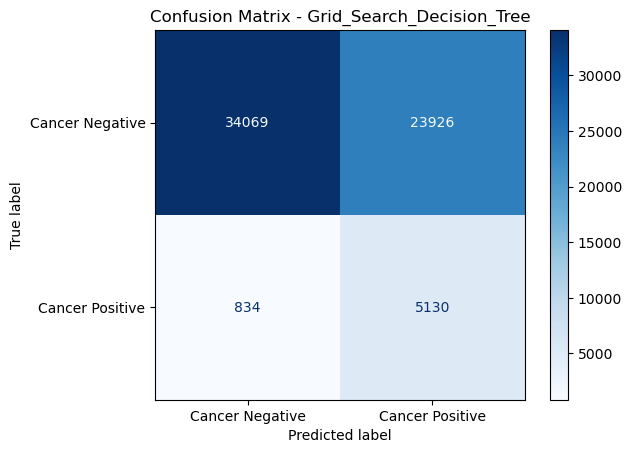

In [47]:
cm = confusion_matrix(y_test_engineered, y_test_rand)

disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                              display_labels = ['Cancer Negative', 'Cancer Positive'])

disp.plot(cmap = 'Blues')
plt.title('Confusion Matrix - Grid_Search_Decision_Tree')

print(classification_report(y_test_engineered, y_test_rand, digits = 4))

The confusion matrix shows that of 63.959 patients, that the model correctly predicts that 5130 of them have cancer and that 34069 of patients do not. It also minimizes the number of missed diagnosis with 834 cases, which further demonstrates the value of high recall within a skewed data set. While the number of false positives are high, they can be eventually found out in futher screening. As such, it is more cost beneficial to have low false negative, while having high false positive. 

<b> The best_tree/Grid Search Decision Tree model is the best one for predicting the skin cancer within patients. The model has a recall score of 86.02 and an accuracy score of 0.6129. Whle other models might have a higher accuracy score, these models fail to take into consideration the imbalance within the dataset. Additionally, the tree is very interpretable, does not need the creation of additional criteria for tuning, and runs faster than most other models.  

<b> It may be possible to produce more powerful models, however these would require more computing power than what my current PC can provide. Also, the models would be very slow, so repeated testing may take longer and longer. 